# House Price - regression

Excercise to predict price of house based on provided features.

[House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [67]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Data understanding

In [68]:
# open description of each feature
with open("../input/data_description.txt", "r") as file:
    print(file.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [69]:
# loading data
train = pd.DataFrame(pd.read_csv("../input/train.csv"))
test = pd.DataFrame(pd.read_csv("../input/test.csv"))

In [70]:
# sample of data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [71]:
# dimensions
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [72]:
# features types
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [73]:
# description of numeric features
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [74]:
# DataFrame with nulls - train set
nulls_summary = pd.DataFrame(train.isnull().any(), columns=['Nulls'])
nulls_summary['Num_of_nulls [qty]'] = pd.DataFrame(train.isnull().sum())
nulls_summary['Num_of_nulls [%]'] = round((train.isnull().mean()*100),2)
print(nulls_summary[nulls_summary["Nulls"]==True])

              Nulls  Num_of_nulls [qty]  Num_of_nulls [%]
LotFrontage    True                 259             17.74
Alley          True                1369             93.77
MasVnrType     True                   8              0.55
MasVnrArea     True                   8              0.55
BsmtQual       True                  37              2.53
BsmtCond       True                  37              2.53
BsmtExposure   True                  38              2.60
BsmtFinType1   True                  37              2.53
BsmtFinType2   True                  38              2.60
Electrical     True                   1              0.07
FireplaceQu    True                 690             47.26
GarageType     True                  81              5.55
GarageYrBlt    True                  81              5.55
GarageFinish   True                  81              5.55
GarageQual     True                  81              5.55
GarageCond     True                  81              5.55
PoolQC        

In [75]:
# missing values - test set
nulls_summary = pd.DataFrame(test.isnull().any(), columns=['Nulls'])
nulls_summary['Num_of_nulls [qty]'] = pd.DataFrame(test.isnull().sum())
nulls_summary['Num_of_nulls [%]'] = round((test.isnull().mean()*100),2)
print(nulls_summary[nulls_summary["Nulls"]==True])

              Nulls  Num_of_nulls [qty]  Num_of_nulls [%]
MSZoning       True                   4              0.27
LotFrontage    True                 227             15.56
Alley          True                1352             92.67
Utilities      True                   2              0.14
Exterior1st    True                   1              0.07
Exterior2nd    True                   1              0.07
MasVnrType     True                  16              1.10
MasVnrArea     True                  15              1.03
BsmtQual       True                  44              3.02
BsmtCond       True                  45              3.08
BsmtExposure   True                  44              3.02
BsmtFinType1   True                  42              2.88
BsmtFinSF1     True                   1              0.07
BsmtFinType2   True                  42              2.88
BsmtFinSF2     True                   1              0.07
BsmtUnfSF      True                   1              0.07
TotalBsmtSF   

## 2. Data Engineering
To aviod having "no value" in data sets, missing values will be filled in with:
1. 0 - for numeric feature or relevant mean/mode value wherever possible
2. "No"/"None" - for categorical feature

In [76]:
train.loc[train["BsmtCond"].isnull(), ["BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual"]] = "No"

In [77]:
train.loc[train["BsmtCond"].isnull(), ["BsmtFinSF1", "BsmtFinSF2", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF"]] = 0

In [78]:
test.loc[test["BsmtHalfBath"].isnull(), "BsmtHalfBath"] = test["BsmtHalfBath"].mode()[0]

In [79]:
train.loc[train["BsmtExposure"].isnull(), "BsmtExposure"] = "No"
test.loc[test["BsmtExposure"].isnull(), "BsmtExposure"] = "No"

In [80]:
train.loc[train["BsmtFinType2"].isnull(), "BsmtFinType2"] = train[train["BsmtFinType2"].isnull()]["BsmtFinType1"]

In [81]:
test.loc[test["BsmtQual"].isnull() & (test["BsmtCond"]=="Fa"), "BsmtQual"] = test[test["BsmtCond"]=="Fa"]["BsmtQual"].mode()[0]
test.loc[test["BsmtQual"].isnull() & (test["BsmtCond"]=="TA"), "BsmtQual"] = test[test["BsmtCond"]=="TA"]["BsmtQual"].mode()[0]

In [82]:
test.loc[test["BsmtQual"].isnull(), ["BsmtFinSF1", "BsmtFullBath", "BsmtUnfSF", "BsmtFinSF2", "TotalBsmtSF"]] = 0

In [83]:
test.loc[test["BsmtQual"].isnull(), ["BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual"]] = "No"

In [84]:
test.loc[test["BsmtCond"].isnull() & (test["BsmtQual"]=="Gd"), "BsmtCond"] = test[test["BsmtQual"]=="Gd"]["BsmtCond"].mode()[0]
test.loc[test["BsmtCond"].isnull() & (test["BsmtQual"]=="TA"), "BsmtCond"] = test[test["BsmtQual"]=="TA"]["BsmtCond"].mode()[0]

In [85]:
train.loc[train["Electrical"].isnull(), "Electrical"] = train["Electrical"].mode()[0]

In [86]:
train.loc[train["MasVnrArea"].isnull(), "MasVnrArea"] = 0
test.loc[test["MasVnrArea"].isnull(), "MasVnrArea"] = 0

In [87]:
train.loc[train["FireplaceQu"].isnull(), "FireplaceQu"] = "No"
test.loc[test["FireplaceQu"].isnull(), "FireplaceQu"] = "No"

In [88]:
train.loc[train["GarageType"].isnull(), ["GarageType", "GarageFinish", "GarageQual"]] = "No"
test.loc[test["GarageType"].isnull(), ["GarageType", "GarageFinish", "GarageQual"]] = "No"
test.loc[test["GarageType"].isnull(), ["GarageCars", "GarageArea"]] = 0

In [89]:
train["LotFrontage"].fillna(0, inplace=True)
test["LotFrontage"].fillna(0, inplace=True)

In [90]:
train["MasVnrType"].fillna("None", inplace=True)
test["MasVnrType"].fillna("None", inplace=True)

In [91]:
train["Alley"].fillna("No", inplace=True)
train["PoolQC"].fillna("No", inplace=True)
train["MiscFeature"].fillna("No", inplace=True)

test["Alley"].fillna("No", inplace=True)
test["PoolQC"].fillna("No", inplace=True)
test["MiscFeature"].fillna("No", inplace=True)

In [92]:
train["Fence"].fillna("No", inplace=True)
test["Fence"].fillna("No", inplace=True)

In [93]:
test.loc[test["GarageFinish"].isnull() & test["GarageCars"]==1, "GarageFinish"] = "Unf"

In [94]:
test.loc[test["GarageFinish"].isnull(), ["GarageType", "GarageFinish", "GarageQual"]] = "No"
test.loc[test["GarageFinish"].isnull(), ["GarageCars", "GarageArea"]] = 0

In [95]:
test.loc[(test["GarageFinish"]=="Unf") & test["GarageQual"].isnull(), "GarageQual"] = test[test["GarageFinish"]=="Unf"]["GarageQual"].mode()[0]

In [96]:
test.loc[test["KitchenQual"].isnull(), "KitchenQual"] = test.loc[train["OverallQual"]==5, "KitchenQual"].mode()[0]

In [97]:
test.loc[test["BsmtHalfBath"].isnull(), "BsmtHalfBath"] = test["BsmtHalfBath"].mode()[0]

In [98]:
test.loc[test["MSZoning"].isnull(), "MSZoning"] = test["MSZoning"].mode()[0]

In [99]:
test.loc[test["GarageCars"].isnull(), ["GarageCars", "GarageArea", "GarageYrBlt"]] = 0
test.loc[test["GarageCars"].isnull(), ["GarageCond"]] = "No"

In [100]:
train.loc[train["GarageYrBlt"].isnull(), "GarageYrBlt"] = 0

In [101]:
# test.loc[test["GarageCond"].isnull() & (test["GarageCars"]!=0), ["GarageType", "GarageFinish", "GarageQual", "GarageCars", 
#                                                                   "GarageArea", "GarageYrBlt", "GarageCond", "YearBuilt", 
#                                                                   "OverallCond"]]

test.loc[test["GarageYrBlt"].isnull() & (test["GarageCars"]!=0), "GarageYrBlt"] = test[test["GarageYrBlt"].isnull() & (test["GarageCars"]!=0)]["YearBuilt"].values[0]
test.loc[test["GarageCond"].isnull() & (test["GarageCars"]!=0), "GarageCond"] = test[test["OverallCond"]==8]["GarageCond"].mode()[0]

In [102]:
test.loc[test["GarageYrBlt"].isnull(), "GarageYrBlt"] = 0

In [103]:
train.loc[train["GarageCond"].isnull(), "GarageCond"] = "No"
test.loc[test["GarageCond"].isnull(), "GarageCond"] = "No"

In [104]:
test.loc[test["Utilities"].isnull(), "Utilities"] = test["Utilities"].mode()[0]

In [105]:
test.loc[test["Exterior1st"].isnull(), "Exterior1st"] = test["Exterior1st"].mode()[0]

In [106]:
test.loc[test["Exterior2nd"].isnull(), "Exterior2nd"] = test["Exterior2nd"].mode()[0]

In [107]:
test.loc[test["Functional"].isnull(), "Functional"] = test["Functional"].mode()[0]

In [108]:
test.loc[test["SaleType"].isnull(), "SaleType"] = test[test["SaleCondition"]=="Normal"]["SaleType"].mode()[0]

In [109]:
# columns with area
for col in train.columns:
    if "Area" in col:
        print(col)

LotArea
MasVnrArea
GrLivArea
GarageArea
PoolArea


## 3. Visualizations

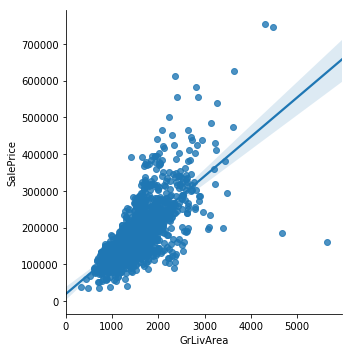

In [110]:
# Visualization of Area features
sns.lmplot("GrLivArea", "SalePrice", data=train)

In [111]:
# drop outliers, low value for high area
train.drop(train.loc[(train["GrLivArea"]>4000) & (train["SalePrice"]<600000)].index, inplace=True)

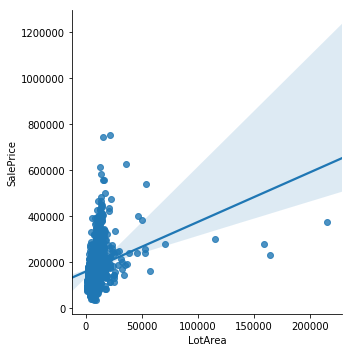

In [112]:
sns.lmplot("LotArea", "SalePrice", data=train)

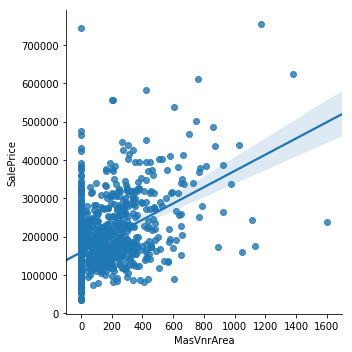

In [113]:
sns.lmplot("MasVnrArea", "SalePrice", data=train)

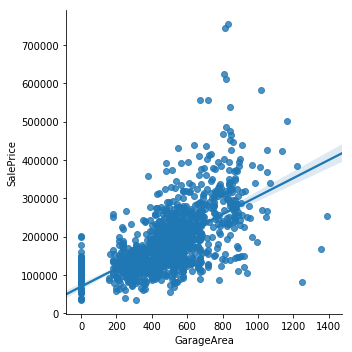

In [114]:
sns.lmplot("GarageArea", "SalePrice", data=train)

In [115]:
train.select_dtypes(exclude=["object"]).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

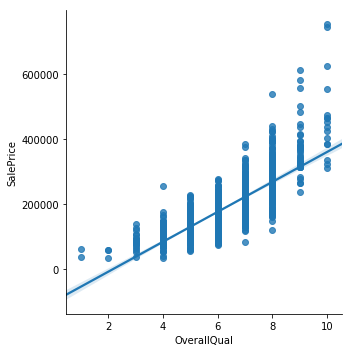

In [116]:
sns.lmplot("OverallQual", "SalePrice", data=train)

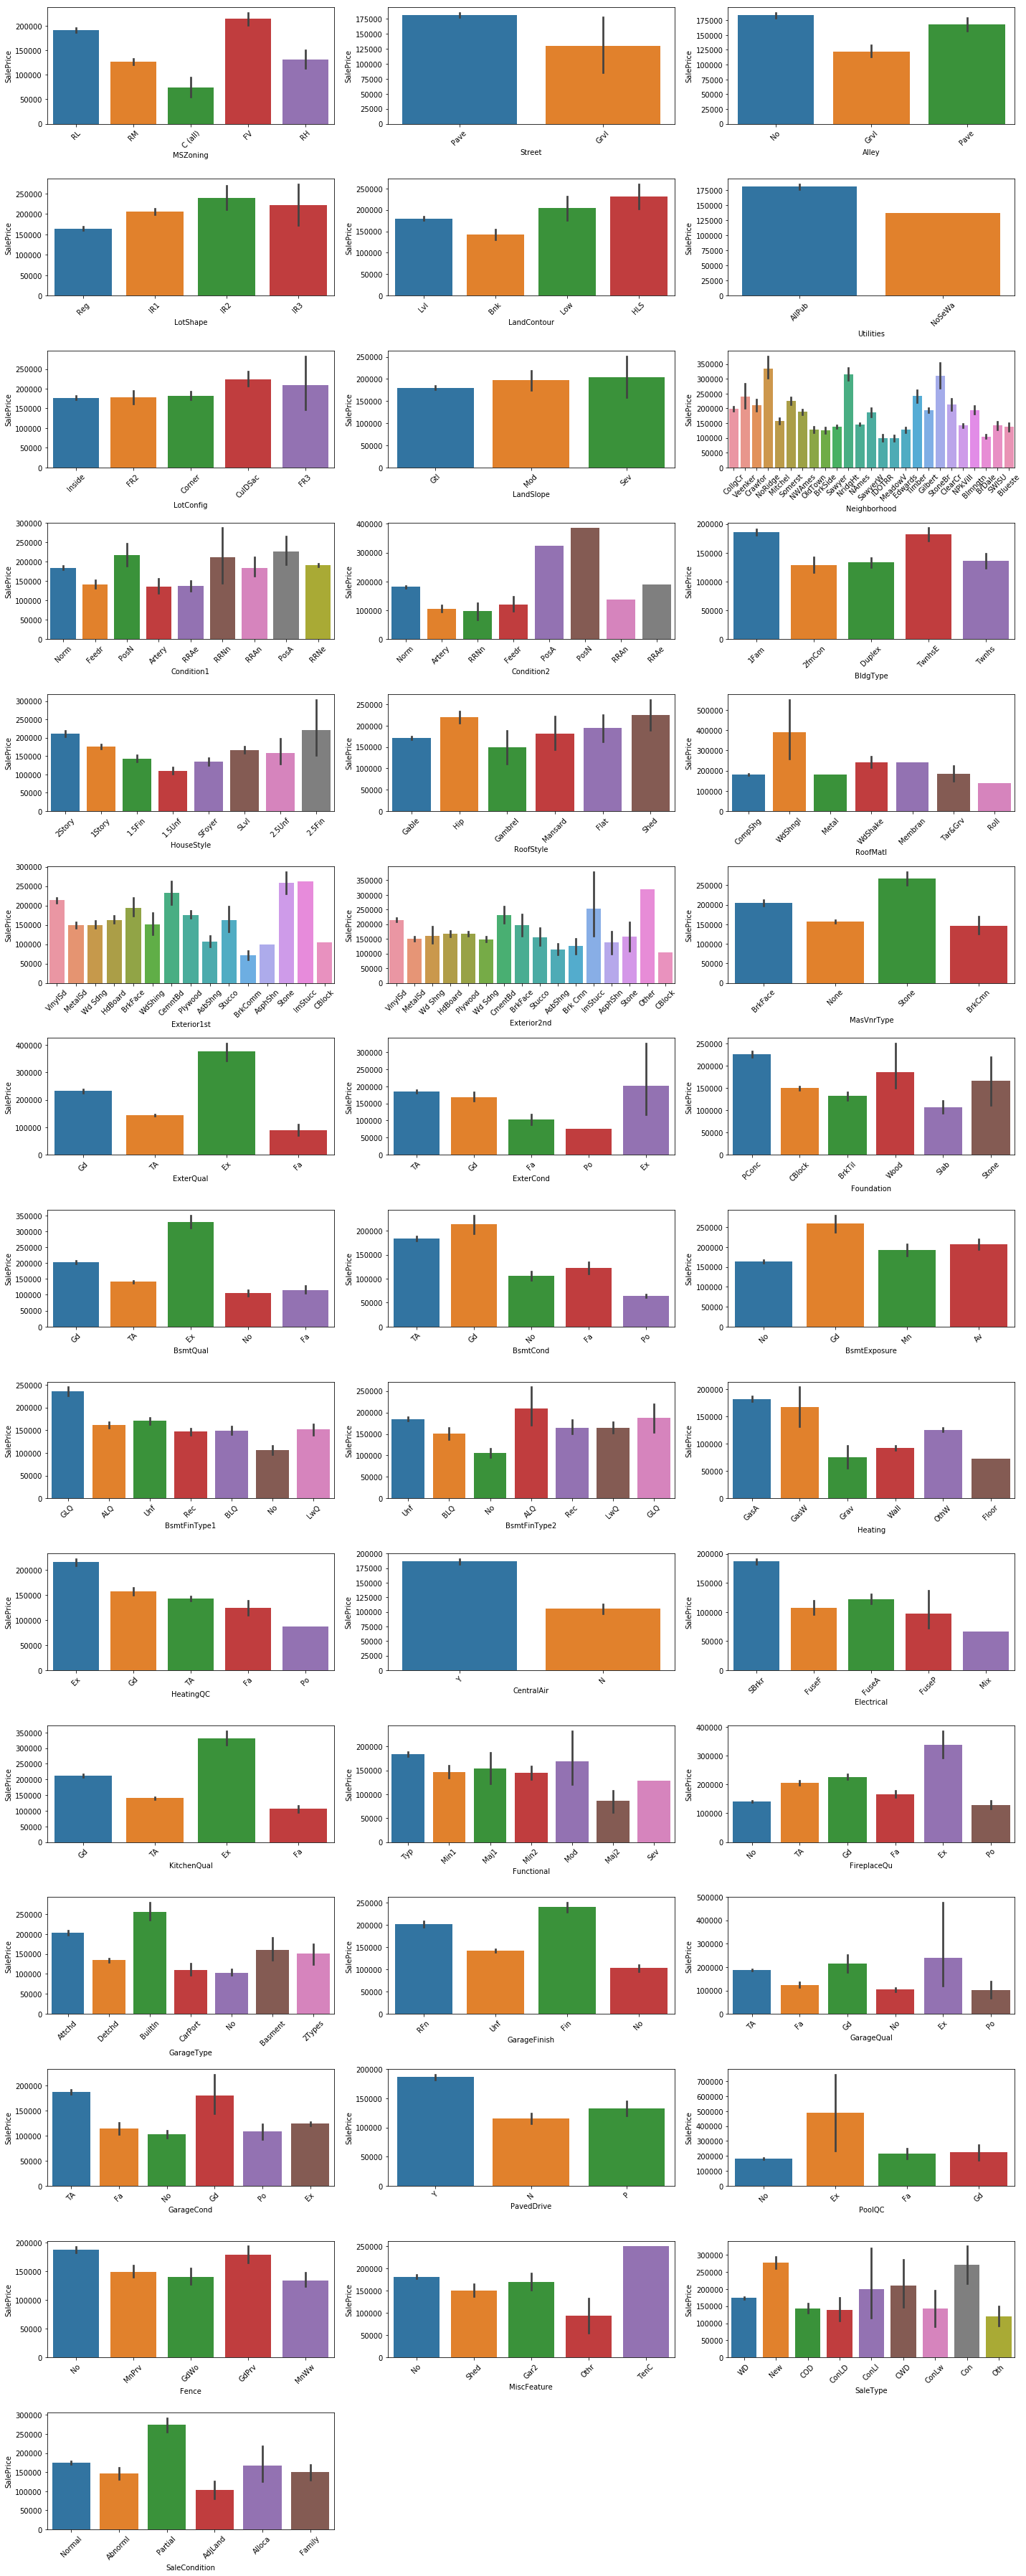

In [117]:
plt.figure(figsize=(20, 50))

for i, column in enumerate(train.select_dtypes(["object"]).columns, 1):
    plt.subplot(15, 3, i)
    sns.barplot(column, "SalePrice", data=train)
    plt.xticks(rotation=45)

plt.tight_layout()

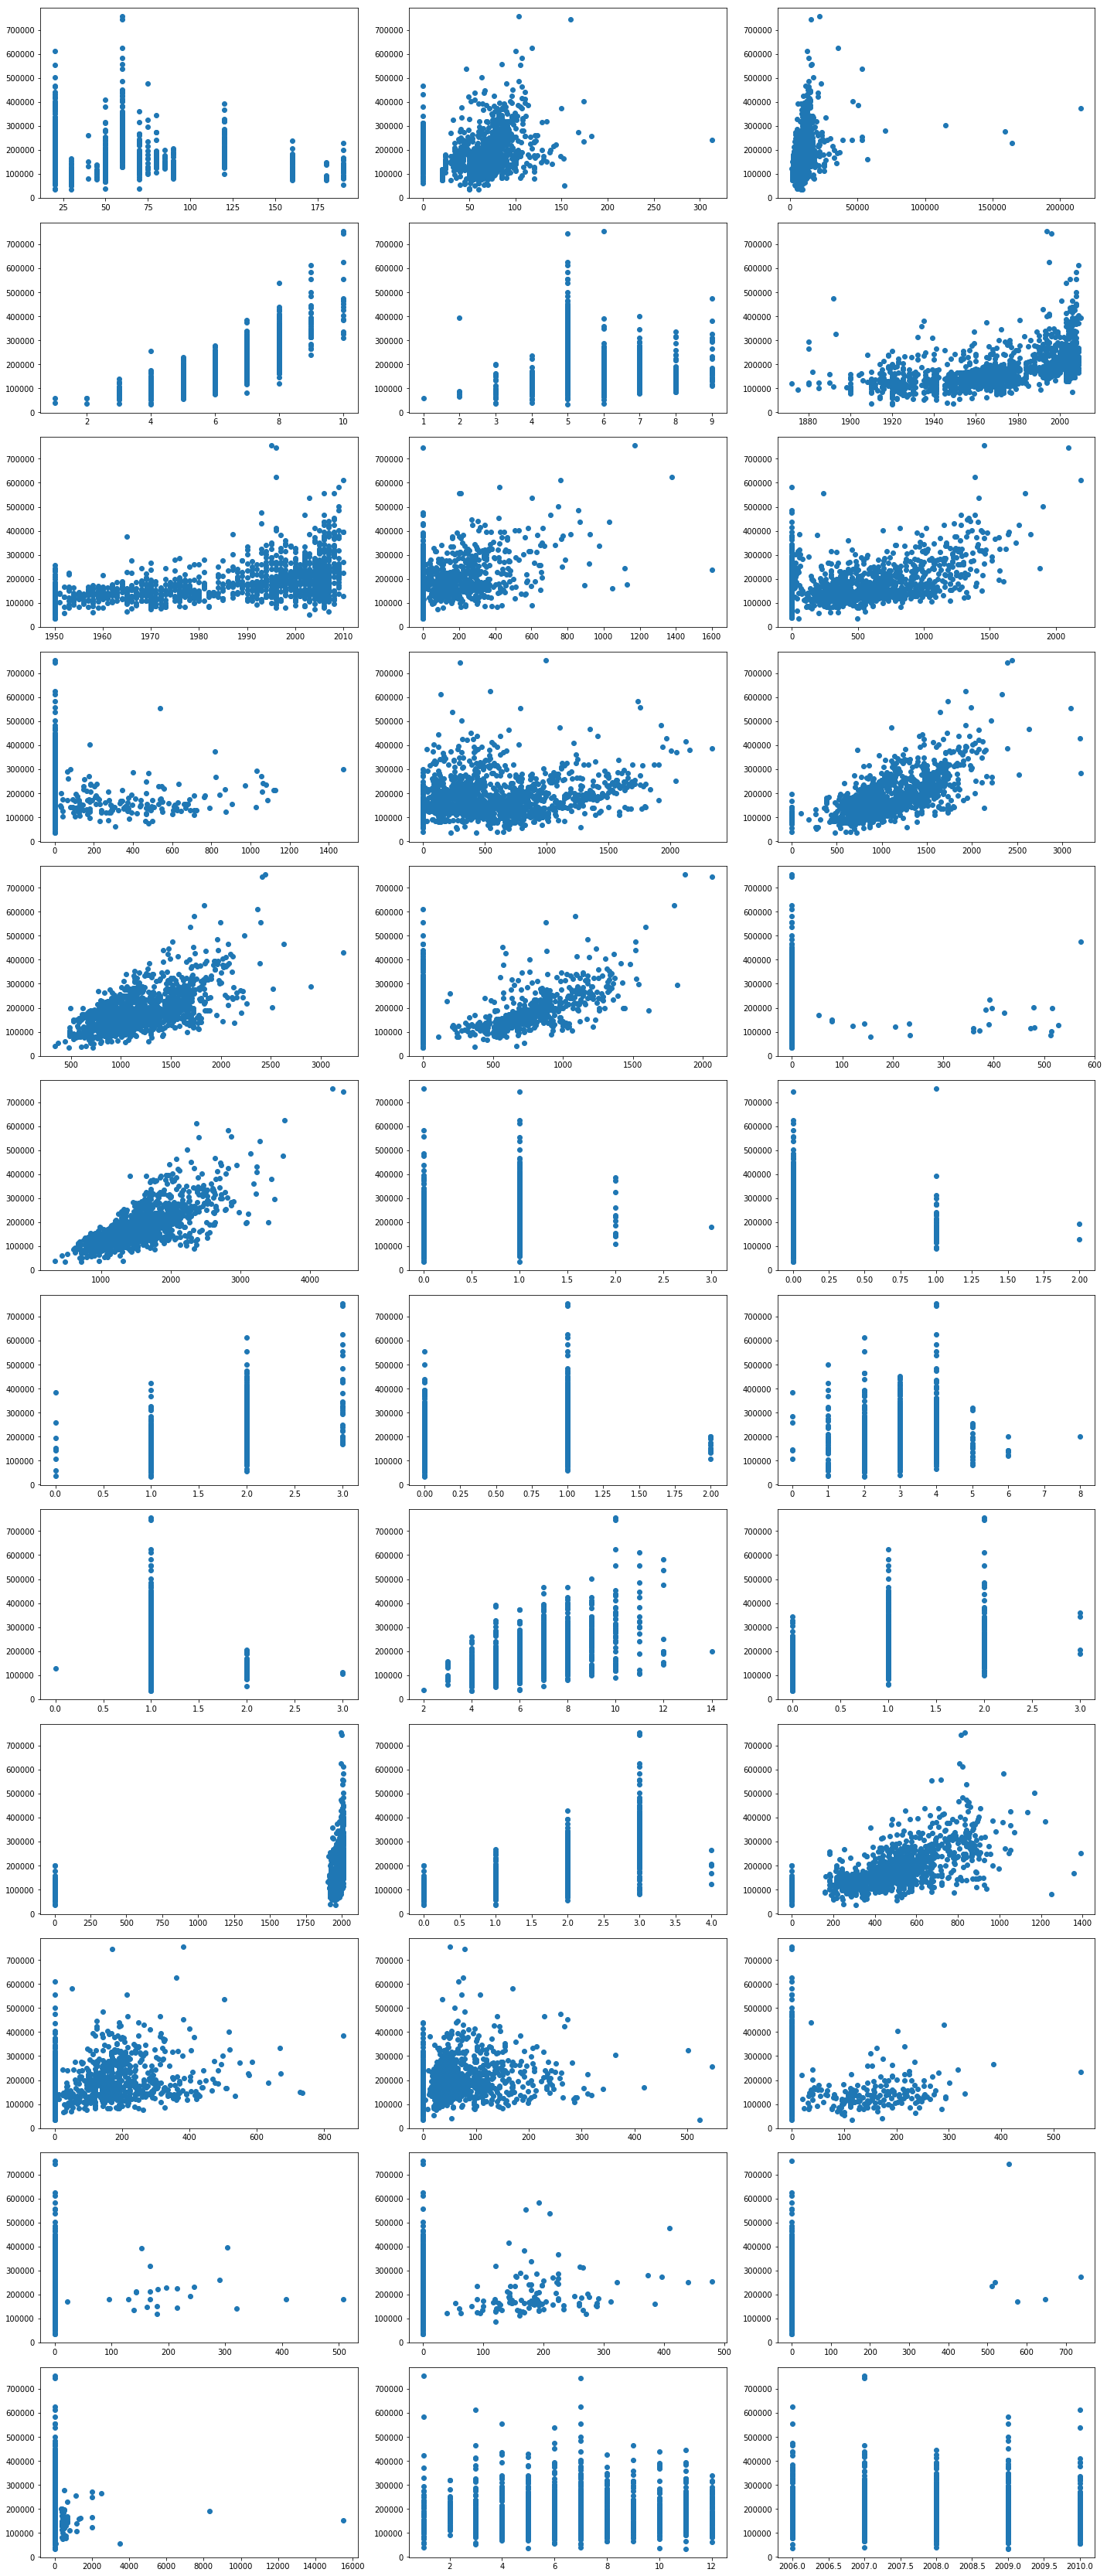

In [118]:
plt.figure(figsize=(20, 50))

for i, column in enumerate(train.drop(["Id", "SalePrice"], axis=1).select_dtypes(exclude=["object"]).columns, 1):
    plt.subplot(13, 3, i)
    plt.scatter(train[column], train["SalePrice"])
#     plt.xticks(rotation=45)

plt.tight_layout()

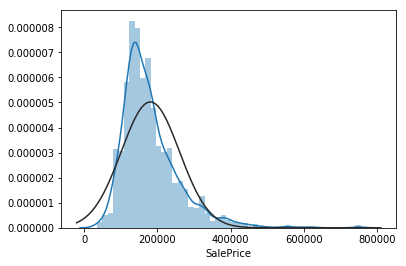

In [119]:
# histogram for Sale Price 
from scipy.stats import norm
sns.distplot(train["SalePrice"], fit=norm)

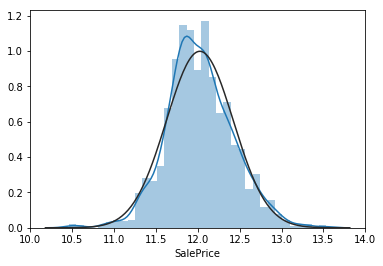

In [120]:
# values of Sale Price are manipulated due right skewed distribution
# now histogram is similar to normal distribution
sns.distplot(np.log1p(train["SalePrice"]), fit=norm)

In [121]:
# replace Sale Price with new logarithmized values
train["SalePrice"] = np.log1p(train["SalePrice"])

In [122]:
# all numeric features with skewness rate lower than -1
# and higher than 1 are logarithmized too
from scipy.stats import skew

skewness = train.select_dtypes(exclude=["object"]).apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 1]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index

train[skewed_features] = np.log1p(train[skewed_features])
test[skewed_features] = np.log1p(test[skewed_features])

16 skewed numerical features to log transform


In [123]:
# saving numeric values to same type
print(train.select_dtypes("float64").columns)
print(test.select_dtypes("float64").columns)

train["BsmtFinSF1"] = train["BsmtFinSF1"].astype("float64")
train["BsmtUnfSF"] = train["BsmtUnfSF"].astype("float64")
train["TotalBsmtSF"] = train["TotalBsmtSF"].astype("float64")
train["BsmtHalfBath"] = train["BsmtHalfBath"].astype("int64")
train["GarageYrBlt"] = train["GarageYrBlt"].astype("int64")
train["GarageArea"] = train["GarageArea"].astype("float64")
test["GarageYrBlt"] = test["GarageYrBlt"].astype("int64")
test["BsmtHalfBath"] = test["BsmtHalfBath"].astype("int64")
test["BsmtFullBath"] = test["BsmtFullBath"].astype("int64")
test["GarageCars"] = test["GarageCars"].astype("int64")

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


In [124]:
# length of train and test set
tr_size = train.shape[0]
te_size = test.shape[0]

In [125]:
# combined sets for creating one hot table
df = pd.concat([train.drop("SalePrice", axis=1), test])

In [126]:
df.shape

(2917, 80)

In [127]:
# one hot table created
X = pd.get_dummies(df).iloc[:tr_size].drop("Id", axis=1)
test_X = pd.get_dummies(df).iloc[tr_size:].drop("Id", axis=1)
y = train["SalePrice"]
print(X.shape)

(1458, 300)


## 4. Machine Learning

In [128]:
# Rigde and Lasso models are tested
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

scorer = make_scorer(rmsle, greater_is_better=False)

cv = 5
folds = KFold(cv, shuffle=True, random_state=0)

In [129]:
# Ridge model
ridge = Ridge()

params = {"alpha": range(0, 20, 2)}

clf = GridSearchCV(ridge, params, cv=folds, n_jobs=-1, scoring=scorer)
clf.fit(X, y)

print(clf.best_score_)
print(clf.best_params_)

# -7.706454931437072e-05
# {'alpha': 12}
# 0.00877864165542544

-0.008728298864631206
{'alpha': 14}


In [130]:
# Lasso model
lasso = Lasso()

params1 = {"alpha": [0.001, 0.01, 0.1, 0.3, 1, 3, 5, 10, 15, 25]}

clf1 = GridSearchCV(lasso, params1, cv=folds, n_jobs=-1, scoring=scorer)
clf1.fit(X, y)

print(clf1.best_score_)
print(clf1.best_params_)

-0.008785360129403442
{'alpha': 0.001}


In [131]:
# chosen mode - Rigde
model = Ridge(**clf.best_params_)
model.fit(X, y)
pred_fin = np.exp(model.predict(test_X))

## 5. File submission

In [132]:
pd.DataFrame({"SalePrice" : pred_fin,
              "Id": test["Id"]}).to_csv("ridge.csv", index=False)

# Kaggle score 